In [1]:
import numpy as np 
import pandas as pd
import pydicom
from typing import Dict
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
import matplotlib.colors as mcolors
from scipy.stats import norm

In [2]:
import sys
sys.path.append('../scripts/') 

from aux_funcs import label_encoder, load_ct_scans, competition_metric, extract_img_id, get_config, make_ct_git, filter_by_std

In [3]:
config = get_config()

In [4]:
train_df = pd.read_csv(config['data_path']+'/train.csv')
test_df = pd.read_csv(config['data_path']+'/test.csv')

In [5]:
le_patient = label_encoder()
le_patient.fit(np.unique(train_df.Patient).tolist())
sex_encoding = {'Male':0, 'Female':1}
status_encoding = {'Currently smokes': np.array([0,0,1]), 'Ex-smoker': np.array([0,1,0]), 'Never smoked': np.array([1,0,0])}

train_df.Patient = train_df.Patient.apply(lambda x: le_patient.transform([x]))
train_df.Sex = train_df.Sex.apply(lambda x: sex_encoding[x])
train_df.SmokingStatus = train_df.SmokingStatus.apply(lambda x: status_encoding[x])

In [6]:
test_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


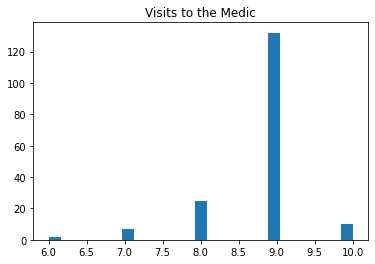

In [7]:
plt.title('Visits to the Medic')
plt.hist(train_df.groupby('Patient')['Age'].count().values, bins=25)
plt.show()

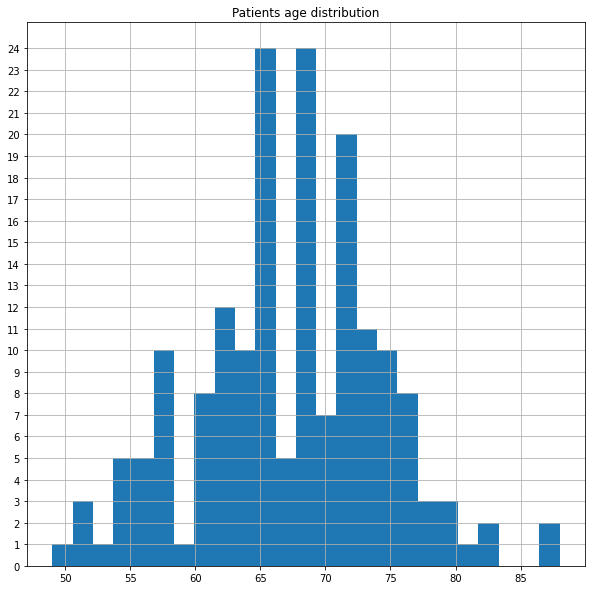

In [8]:
plt.figure(figsize=(10,10))
plt.title('Patients age distribution')
plt.yticks(np.arange(0,25), np.arange(0,25))
plt.hist(train_df.groupby('Patient')['Age'].mean().values, bins=25)
plt.grid()
plt.show()

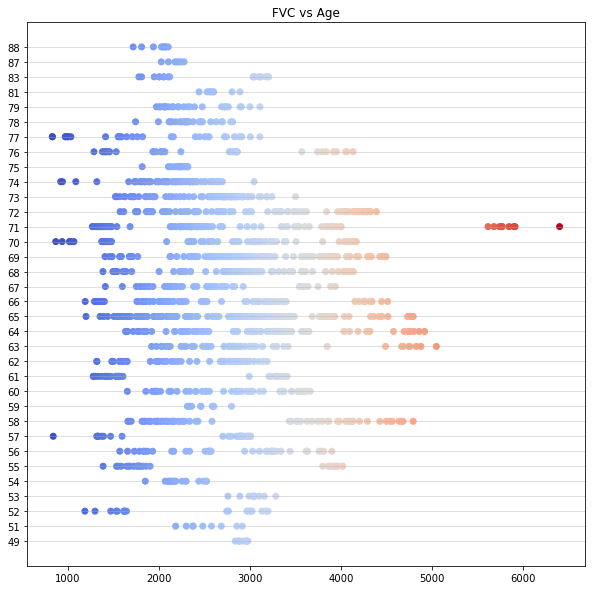

In [9]:
ages = np.sort(np.unique(train_df['Age'].values))
fvc_per_age = [train_df[train_df['Age']==x]['FVC'].values for x in ages]

plt.figure(figsize=(10,10))
plt.title('FVC vs Age')
plt.yticks(np.arange(0,34), ages)
plt.grid(axis='y',linestyle='-', alpha=0.5)

for i in range(ages.shape[0]):
    plt.scatter(fvc_per_age[i], i*np.ones_like(fvc_per_age[i]), c=(fvc_per_age[i]/train_df['FVC'].max()), vmin=train_df['FVC'].min()/train_df['FVC'].max(), vmax=1, cmap='coolwarm')

plt.show()

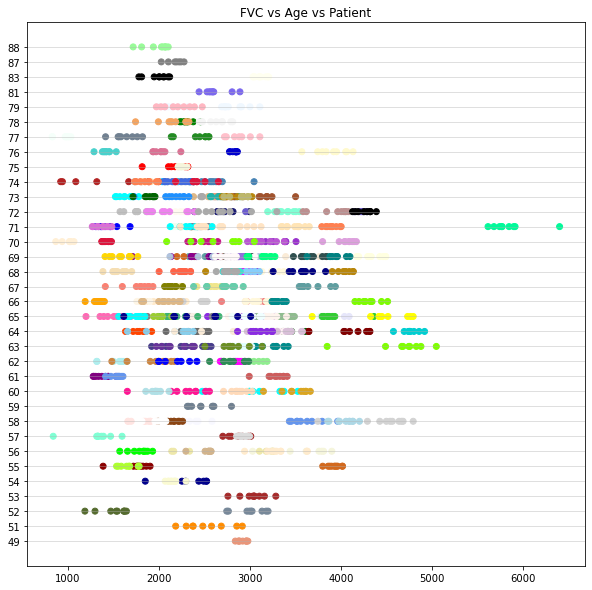

In [10]:
colors =[x for x in mcolors.CSS4_COLORS.values()]

ages = np.sort(np.unique(train_df['Age'].values))
fvc_per_age = [train_df[train_df['Age']==x]['FVC'].values for x in ages]
patients_per_age = [train_df[train_df['Age']==x]['Patient'].values for x in ages]

plt.figure(figsize=(10,10))
plt.title('FVC vs Age vs Patient')
plt.yticks(np.arange(0,34), ages)
plt.grid(axis='y',linestyle='-', alpha=0.5)

for i in range(ages.shape[0]):
    plt.scatter(fvc_per_age[i], i*np.ones_like(fvc_per_age[i]), c=[colors[x%len(colors)] for x in patients_per_age[i]])

plt.show()

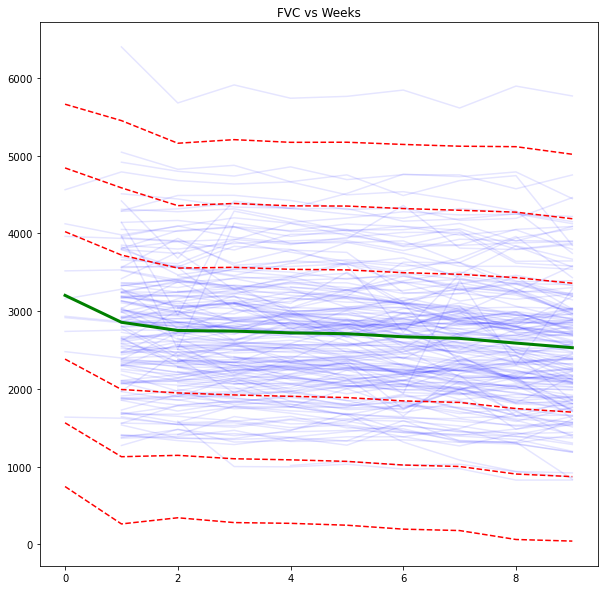

"\n\nvals = train_df['FVC'].values\n\nplt.figure(figsize=(10,10))\nplt.hist(train_df['FVC'].values, bins=1000)\nrv = norm(loc=np.mean(vals), scale=np.std(vals))\nx = np.arange(np.mean(vals)-5*np.std(vals),np.mean(vals)+5*np.std(vals),0.1)\nplt.plot(x, 9*rv.pdf(x)/0.0005, 'k-', lw=2)\nplt.show()"

In [11]:
fvc_matrix = np.empty((176,10)) * np.nan

plt.figure(figsize=(10,10))
plt.title('FVC vs Weeks')
for x in np.unique(train_df.Patient):
    mask = train_df.Patient == x
    vals = train_df['FVC'].values[mask]
    fvc_matrix[x,-vals.shape[0]:] = vals
    plt.plot(fvc_matrix[x], color='b', alpha=0.1)

mu = np.nanmean(fvc_matrix, axis=0)
std = np.nanstd(fvc_matrix, axis=0)

plt.plot(mu, c='g', linewidth=3)
plt.plot(mu+std, c='r',linestyle='--')
plt.plot(mu-std, c='r',linestyle='--')
plt.plot(mu+2*std, c='r',linestyle='--')
plt.plot(mu-2*std, c='r',linestyle='--')
plt.plot(mu+3*std, c='r',linestyle='--')
plt.plot(mu-3*std, c='r',linestyle='--')

plt.show()

'''

vals = train_df['FVC'].values

plt.figure(figsize=(10,10))
plt.hist(train_df['FVC'].values, bins=1000)
rv = norm(loc=np.mean(vals), scale=np.std(vals))
x = np.arange(np.mean(vals)-5*np.std(vals),np.mean(vals)+5*np.std(vals),0.1)
plt.plot(x, 9*rv.pdf(x)/0.0005, 'k-', lw=2)
plt.show()'''

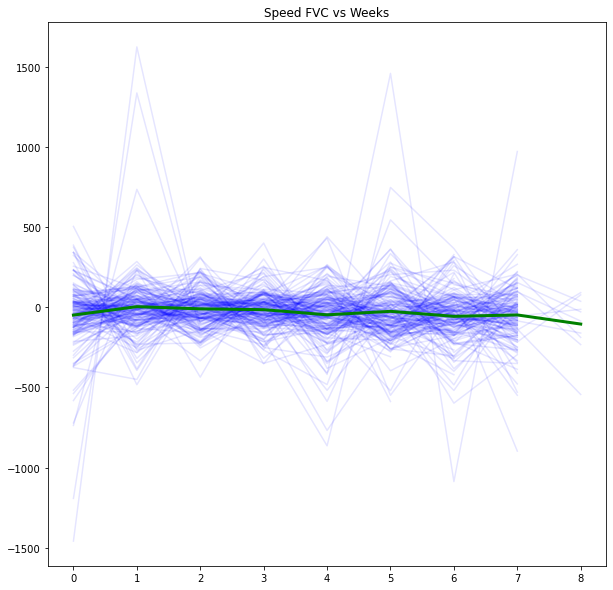

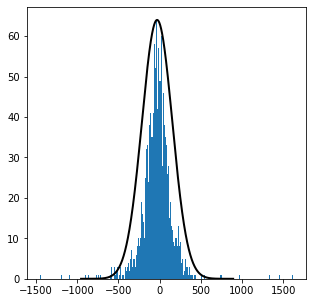

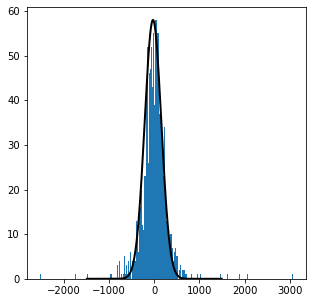

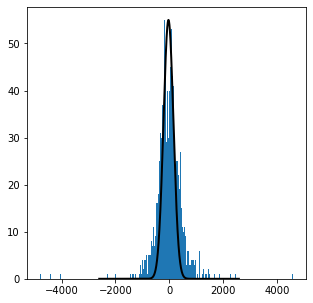

In [12]:
diff1 = []
diff2 = []
diff3 = []
fvc_matrix = np.empty((176,10)) * np.nan

plt.figure(figsize=(10,10))
plt.title('Speed FVC vs Weeks')
for x in np.unique(train_df.Patient):
    mask = train_df.Patient == x
    vals = train_df['FVC'].values[mask]
    diff_vals = np.diff(vals,1)
    fvc_matrix[x,:vals.shape[0]-1] = diff_vals
    plt.plot(fvc_matrix[x], color='b', alpha=0.1)

    for x in diff_vals:
        diff1.append(x)
    diff_vals = np.diff(vals,2)
    for x in diff_vals:
        diff2.append(x)
    diff_vals = np.diff(vals,3)
    for x in diff_vals:
        diff3.append(x)

mu = np.nanmean(fvc_matrix, axis=0)
std = np.nanstd(fvc_matrix, axis=0)

plt.plot(mu, c='g', linewidth=3)
plt.show()

plt.figure(figsize=(5,5))
C = plt.hist(diff1, bins=256)
rv = norm(loc=np.mean(diff1), scale=np.std(diff1))
x = np.arange(np.mean(diff1)-5*np.std(diff1),np.mean(diff1)+5*np.std(diff1),0.1)
plt.plot(x, np.max(C[0])*rv.pdf(x)/np.max([rv.pdf(xx) for xx in x]), 'k-', lw=2)
plt.show()
plt.figure(figsize=(5,5))
C = plt.hist(diff2, bins=256)
x = np.arange(np.mean(diff2)-5*np.std(diff2),np.mean(diff2)+5*np.std(diff2),0.1)
plt.plot(x, np.max(C[0])*rv.pdf(x)/np.max([rv.pdf(xx) for xx in x]), 'k-', lw=2)
plt.show()
plt.figure(figsize=(5,5))
C = plt.hist(diff3, bins=256)
x = np.arange(np.mean(diff3)-5*np.std(diff3),np.mean(diff3)+5*np.std(diff3),0.1)
plt.plot(x, np.max(C[0])*rv.pdf(x)/np.max([rv.pdf(xx) for xx in x]), 'k-', lw=2)
plt.show()

In [ ]:
for x in np.unique(train_df['Patient'].values):
    mask = train_df['Patient'].values == x
    plt.scatter(train_df['FVC'].values[mask], train_df['Percent'].values[mask], alpha=0.2)
    plt.plot(train_df['FVC'].values[mask], train_df['Percent'].values[mask], alpha=0.2)
plt.show()

In [13]:
data = load_ct_scans(config['data_path']+'/train', le_patient)

100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


In [14]:
for k,v in tqdm(data.items()):
    make_ct_git(v, '../data/gifs/'+str(k)+'gif')

 80%|███████▉  | 140/176 [25:42<06:36, 11.01s/it]


CalledProcessError: Command '['convert', '-size', '432x288', '-depth', '8', '-delay', '10.0', '-loop', '0', 'rgba:-', '../data/gifs/140gif']' returned non-zero exit status 2.